## Importation des modules et des données 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
acte = pd.read_csv("acte.csv", sep = ";")
ccam = pd.read_csv("ccam.csv",sep = ";")
h = pd.read_csv("h.csv",sep = ";")

## Création du tableau de données exploitable

### Merge des tableaux

In [4]:
data = h.merge(acte)

In [5]:
data = data.merge(ccam).sort_values('i')

### Création du tableau d'étude

In [6]:
def get_val(values):
    return list(values)
def get_count(values):
    return len(values)
def get_chap(values):
    return list(set(values))

In [7]:
df = data.groupby('i').ccam_code.agg(get_val)
df = df.to_frame()
df["nb_codes"] = df.ccam_code.agg(get_count)
df["d"] = data.groupby('i').d.mean()
df["ccam_lib"] = data.groupby('i').ccam_lib.agg(get_val)

In [8]:
df['chapitre'] = data.groupby('i').chapitre_lib.agg(get_chap)
df['sous_chapitre'] = data.groupby('i').sous_chapitre_lib.agg(get_chap)
df['paragraphe']= data.groupby('i').paragraphe_lib.agg(get_chap)
df['sous_paragraphe'] = data.groupby('i').sous_paragraphe_lib.agg(get_chap)

### Création du tableau de contingence

In [9]:
X = pd.DataFrame()

In [10]:
list_codes = data['ccam_lib'].unique()
for i in range (len(list_codes)):
    X[str(list_codes[i])] = df['ccam_lib'].apply(lambda x : x.count(list_codes[i]))
X.head(5)

,"Ablation d'une endoprothèse urétérale, par endoscopie rétrograde","Changement d'une endoprothèse urétérale, par endoscopie rétrograde",Urétéropyélographie rétrograde [UPR],Urétrocystoscopie à l'endoscope rigide,Guidage radiologique,"Changement d'une sonde urétérale, par endoscopie rétrograde",Supplément pour injection peropératoire de produit de contraste radiologique dans les voies excrétrices urinaires pour prises de clichés radiologiques,"Fragmentation intrarénale de calcul caliciel inférieur avec ondes de choc ou laser [Lithotritie intrarénale], par urétéronéphroscopie",Pose d'une sonde urétrovésicale [Sondage vésical à demeure],"Résection d'une hypertrophie de la prostate sans laser, par urétrocystoscopie",...,"Ablation d'électrode de stimulation de la moelle épinière, par abord direct","Thromboendartériectomie iliaque, par laparotomie",Urétroplastie chez la femme,"Lavage des corps caverneux du pénis, par voie transcutanée","Épididymectomie, par abord scrotal","Suture de rupture du testicule, par abord scrotal","Prélèvement d'un rein sur un donneur vivant, par abord direct","Lithotritie extracorporelle de l'uretère, avec guidage radiologique","Exploration du contenu scrotal, par abord inguinal",Fermeture du vagin
i,,,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
list_chap = data['chapitre_lib'].unique()
list_sous_chap = data['sous_chapitre_lib'].unique()
list_para = data['paragraphe_lib'].unique()
list_sous_para = data['sous_paragraphe_lib'].unique()

for i in range (len(list_chap)):
    X[str(list_chap[i])] = df['chapitre'].apply(lambda x : 1 if list_chap[i] in x else 0)
    
for i in range (len(list_sous_chap)):
    X[str(list_sous_chap[i])] = df['chapitre'].apply(lambda x : 1 if list_sous_chap[i] in x else 0)
    
for i in range (len(list_para)):
    X[str(list_para[i])] = df['chapitre'].apply(lambda x : 1 if list_para[i] in x else 0)
    
for i in range (len(list_sous_para)):
    X[str(list_sous_para[i])] = df['chapitre'].apply(lambda x : 1 if list_sous_para[i] in x else 0)

In [12]:
X["nb_codes"] = df["nb_codes"]
X["d"] = df["d"]

### Résaux de neuronnes pour la regression 

In [13]:
from sklearn import ensemble,model_selection
from sklearn.neural_network import MLPRegressor

In [14]:
clf = MLPRegressor(hidden_layer_sizes=(100,150,100), activation='relu', alpha=0.005, learning_rate_init=0.001, max_iter=1000, random_state=0)

In [15]:
features = X.drop(columns = 'd') # les données sans la durée
label = X['d'] # les label à prédire

#### Création du jeu d'entrainement et de test

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, label, test_size=0.33)
#y_train = np.log(y_train) # Si valeur en log
#y_test = np.log(y_test)

#### Entrainement

In [17]:
fig = clf.fit(X_train,y_train)

#### Phase de test

In [18]:
p = fig.predict(X_test) # prédiction
MAPE = np.mean(abs(p-y_test)*100/y_test)

In [19]:
#PE = (np.exp(p)-np.exp(y_test))*100/np.exp(y_test)
PE = (p-y_test)*100/y_test

within, overage, underage = 0, 0, 0
for i in PE:
    if i < -10:
        underage += 1
    elif i > 10:      # Il y avait une faute ici dans le rapport de l'an dernier, 
                     # il y avait simple if ou lieu de elif
        overage += 1
    else : 
        within += 1
        
total = within + overage + underage
within = within*100/total
overage = overage*100/total
underage = underage*100/total


print("Résultat pour TOUT JEUX DE DONNEE")
print("Score sur le jeu de test : ",fig.score(X_test,y_test))
print("MAPE : ", MAPE)
print("dans l'intervalle 10% : ", within)
print("Surestimé : ",overage)
print("Sous estimé : ",underage)

Résultat pour TOUT JEUX DE DONNEE
Score sur le jeu de test :  0.6907961423483275
MAPE :  34.40343642532377
dans l'intervalle 10% :  25.379310344827587
Surestimé :  46.206896551724135
Sous estimé :  28.413793103448278


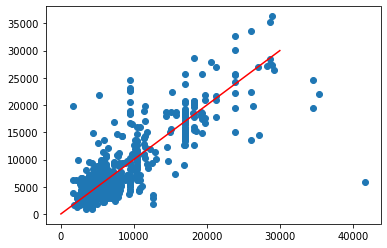

In [20]:
plt.scatter(p,y_test)
plt.plot([50,30000],[50,30000],"-r")
plt.show()